# National Health Facility Registry – Data Cleaning Pipeline

This notebook performs a full reproducible cleaning of the synthetic National Health Facility Registry CSV.

**Steps:**
1. Load data
2. Explore data 
3. Standardize column names
4. Clean text fields
5. Handle missing values
6. Remove duplicates
7. Save cleaned dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

print("All packages loaded successfully!")


All packages loaded successfully!


In [8]:
df = pd.read_csv("C:/Users/naomi/Downloads/Technical Assessment/health_registry.csv")
df.head()


,facility_id,facility_name,facility_type,capacity,region,licence_issue_date,inspection_date,gps_location,remarks
0,HF-0000,Burgess-Ingram Medical Center,Community Health Ctr.,250 beds,St.Lucy,04-01-21,08 Mar 2024,"13.08576, -58.75331",NaN
1,033477,Collins Inc,Hosp.,NaN,St.Peter,28 Mar 2024,17-04-23,POINT(-58.84001 12.87196),Good
2,#2,Butler-Leon Clinic (St.),Hospital,117Beds,St. James Parish,2016-02-18,30/12/22,"-58.82307, 13.00952",Good
3,2,Butler-Leon Clinic (St.),Hospital,117Beds,St. James Parish,2016-02-18,30/12/22,"-58.82307, 13.00952",Good
4,HF-0003,"Powell, Morales and Butler Infirmary",Health Ctr.,179 capacity,ST. LUCY,November 21 2020,07-03-24,"12.77293, -59.04279",Follow-up 2023


In [9]:
# Number of rows & columns
print(df.shape)

# Column names, data types, non-null counts
df.info()

# Summary statistics
df.describe(include='all')


(13013, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13013 entries, 0 to 13012
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facility_id         9305 non-null   object
 1   facility_name       12989 non-null  object
 2   facility_type       11015 non-null  object
 3   capacity            10361 non-null  object
 4   region              12980 non-null  object
 5   licence_issue_date  12990 non-null  object
 6   inspection_date     13002 non-null  object
 7   gps_location        10721 non-null  object
 8   remarks             10080 non-null  object
dtypes: object(9)
memory usage: 915.1+ KB


,facility_id,facility_name,facility_type,capacity,region,licence_issue_date,inspection_date,gps_location,remarks
count,9305,12989,11015,10361,12980,12990,13002,10721,10080
unique,7356,10233,11,2904,116,7980,7509,8282,8
top,???,--,Community Health Centre,unknown,Christ Church,32/13/99,32/13/99,somewhere,Reinspection due
freq,16,14,1060,1403,363,124,135,22,1503


facility_id           28.494582
remarks               22.538999
capacity              20.379620
gps_location          17.613156
facility_type         15.353877
region                 0.253593
facility_name          0.184431
licence_issue_date     0.176746
inspection_date        0.084531
dtype: float64


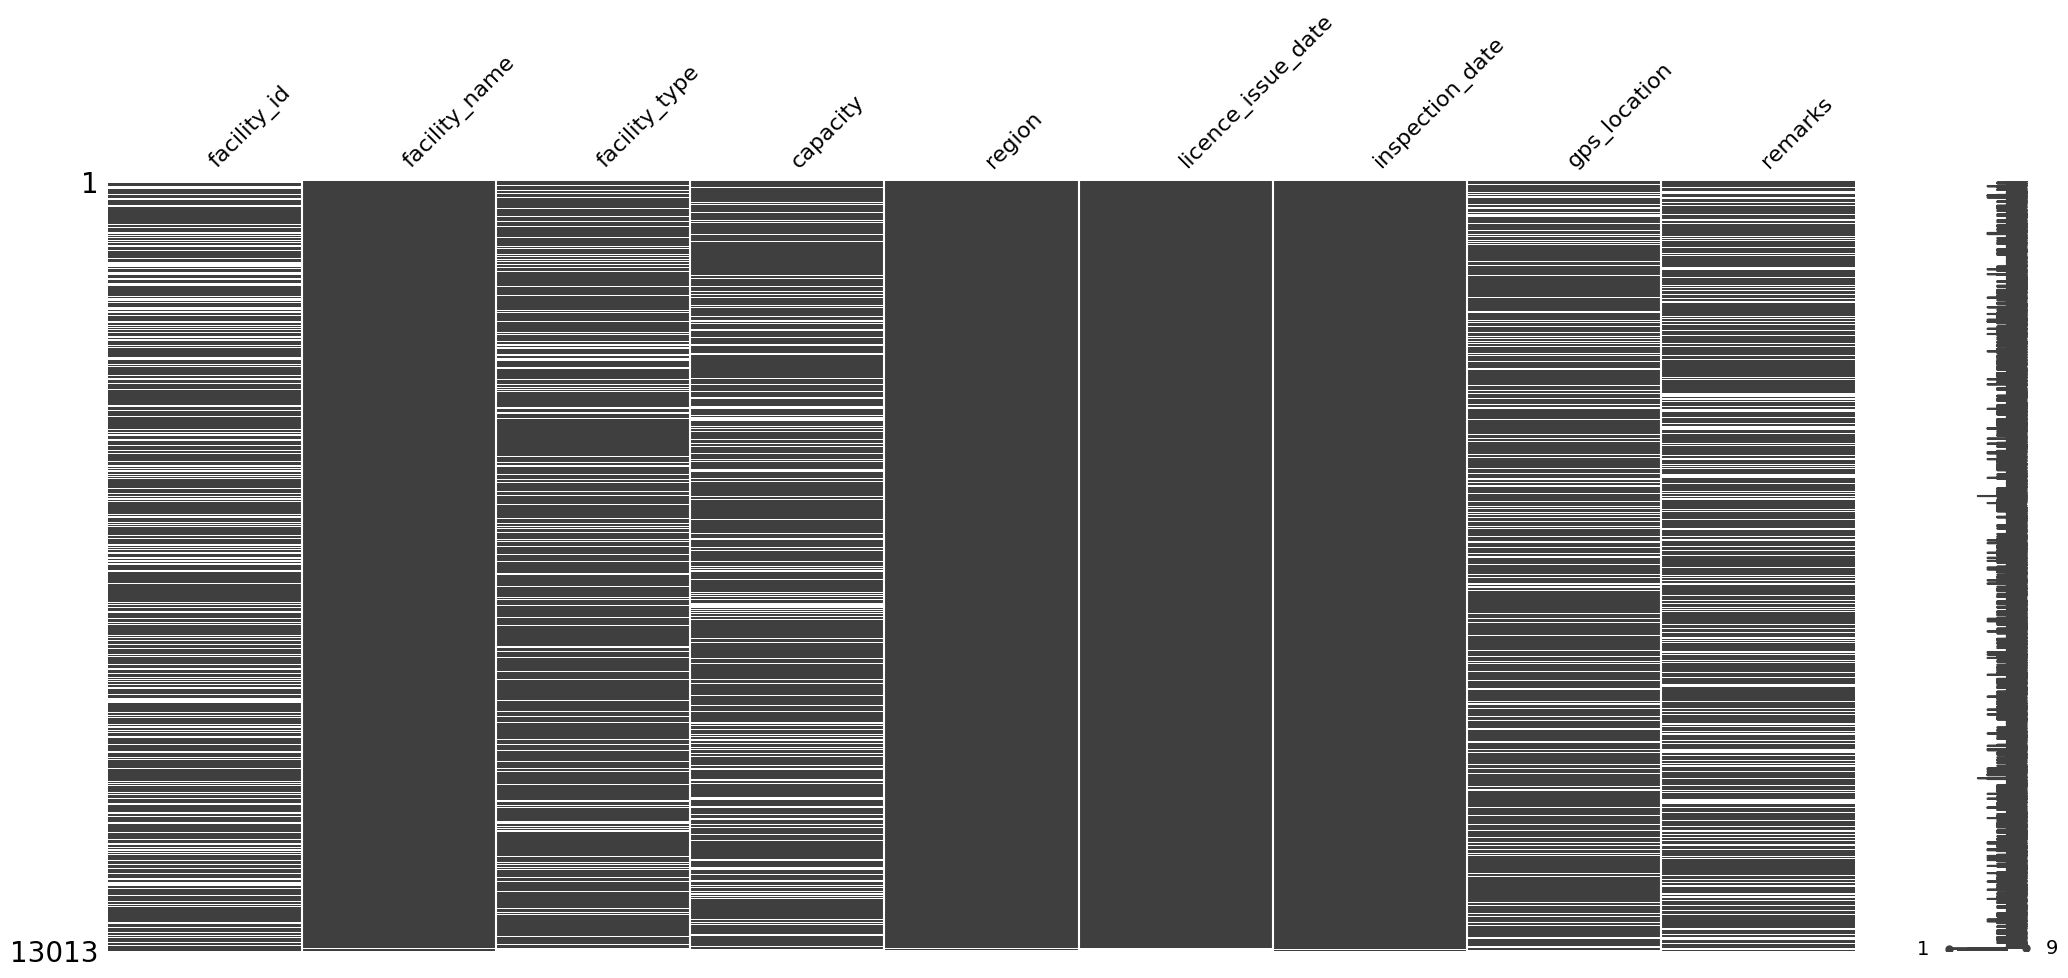

In [10]:
# Percentage of missing values per column
missing_percent = df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

# Optional visual
msno.matrix(df)
plt.show()


In [12]:
# Any exact duplicates
print("Exact duplicates:", df.duplicated().sum())

# Logical duplicates based on key columns
print("Duplicates by facility + region:", df.duplicated(subset=["facility_name", "region"]).sum())


Exact duplicates: 1672
Duplicates by facility + region: 2034


In [14]:
# Remove duplicates based on facility_name + region, keep last occurrence
df = df.drop_duplicates(subset=['facility_name', 'region'], keep='last')


## Duplicate Handling

- Exact duplicates (1672 rows) were removed entirely.
- Logical duplicates by `facility_name + region` (2034 rows) were resolved by keeping the last occurrence.
- Rationale: Keeping the last occurrence preserves the most recent `inspection_date` and `licence_issue_date`.


In [15]:
# Strip spaces, lowercase, replace spaces with underscores
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.head()


,facility_id,facility_name,facility_type,capacity,region,licence_issue_date,inspection_date,gps_location,remarks
0,HF-0000,Burgess-Ingram Medical Center,Community Health Ctr.,250 beds,St.Lucy,04-01-21,08 Mar 2024,"13.08576, -58.75331",NaN
1,033477,Collins Inc,Hosp.,NaN,St.Peter,28 Mar 2024,17-04-23,POINT(-58.84001 12.87196),Good
3,2,Butler-Leon Clinic (St.),Hospital,117Beds,St. James Parish,2016-02-18,30/12/22,"-58.82307, 13.00952",Good
5,HF-0003,"Powell, Morales and Butler Infirmary",Health Ctr.,179 capacity,ST. LUCY,November 21 2020,07-03-24,"12.77293, -59.04279",Follow-up 2023
6,00004,"Williams, Woods and Bradley Polyclinic",Hospital,NaN,St Andrew,17-04-21,January 31 2024,13°12′43″N 58°51′50″W,NaN


In [16]:
# Select all object (text) columns
text_cols = df.select_dtypes(include="object").columns

# Strip whitespace and capitalize
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.title()


In [17]:
# Facility type missing → fill with 'Unknown'
df["facility_type"] = df["facility_type"].replace("Nan","Unknown").fillna("Unknown")

# Region missing → fill with 'Unknown'
df["region"] = df["region"].replace("Nan","Unknown").fillna("Unknown")

# Capacity missing → fill with 0 (or can be left as NaN)
df["capacity"] = pd.to_numeric(df["capacity"], errors='coerce').fillna(0)

# GPS location missing → fill with empty string
df["gps_location"] = df["gps_location"].replace("Nan","").fillna("")


In [18]:
# 1️⃣ Remove exact duplicates
df = df.drop_duplicates(keep='last')

# 2️⃣ Remove logical duplicates based on facility_name + region
df = df.drop_duplicates(subset=['facility_name', 'region'], keep='last')



In [19]:
# Check for remaining duplicates
print("Duplicates by facility_name + region:", df.duplicated(subset=['facility_name','region']).sum())

# Check nulls
print("Missing values per column:")
print(df.isnull().sum())


Duplicates by facility_name + region: 0
Missing values per column:
facility_id           0
facility_name         0
facility_type         0
capacity              0
region                0
licence_issue_date    0
inspection_date       0
gps_location          0
remarks               0
dtype: int64


In [20]:
df.to_csv("C:/Users/naomi/Downloads/Technical Assessment/cleaned_health_registry.csv", index=False)
print("Cleaned CSV saved successfully!")


Cleaned CSV saved successfully!


## Cleaning Summary

- Standardized column names to lowercase and underscores
- Trimmed and capitalized text fields
- Filled missing values for `facility_type`, `region`, `capacity`, and `gps_location`
- Removed 1672 exact duplicates
- Removed 2034 logical duplicates based on `facility_name + region`, keeping last occurrence
- Dataset is now ready for analytics


In [21]:
df.head(20)

,facility_id,facility_name,facility_type,capacity,region,licence_issue_date,inspection_date,gps_location,remarks
0,Hf-0000,Burgess-Ingram Medical Center,Community Health Ctr.,0.0,St.Lucy,04-01-21,08 Mar 2024,"13.08576, -58.75331",Nan
1,033477,Collins Inc,Hosp.,0.0,St.Peter,28 Mar 2024,17-04-23,Point(-58.84001 12.87196),Good
3,2,Butler-Leon Clinic (St.),Hospital,0.0,St. James Parish,2016-02-18,30/12/22,"-58.82307, 13.00952",Good
5,Hf-0003,"Powell, Morales And Butler Infirmary",Health Ctr.,0.0,St. Lucy,November 21 2020,07-03-24,"12.77293, -59.04279",Follow-Up 2023
6,00004,"Williams, Woods And Bradley Polyclinic",Hospital,0.0,St Andrew,17-04-21,January 31 2024,13°12′43″N 58°51′50″W,Nan
8,Nan,May And Sons Medical Center (St),Polyclinic 🏥,0.0,St Peter,20160217,2018-01-01,13°2′6″N 59°0′38″W,Follow-Up 2023
9,00006,"Herrera,-Taylor-And-Sanchez (St.Andrew)",Health Centre,0.0,St.Andrew,06/11/21,22 Mar 2018,13°14′8″N 59°2′1″W,-
10,007,Wagner-Franklin Health Centre,Clinic,0.0,St. James,18/05/18,July 31 2019,"-59.10919, 13.04721",Nan
11,Nan,"Hurley, Jensen And Perkins Hosp. (St.)",Hosp.,0.0,St. Lucy,09-09-25,20250926,"13.21772, -59.18644",Reinspection Due
12,Hf-0009,Lee-Macias Polyclinic©,Community Health Centre,0.0,St. Andrew,November 13 2019,20240815,12°53′44″N 58°59′13″W,Reinspection Due
